# Discovery Lap Logic for the turtlebot3

In [1]:
# Necessary imports
import path_planning as tr
import matplotlib.pyplot as plt
import pickle, numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull, Delaunay
from scipy.interpolate import splprep, splev
from scipy.misc import derivative

# Plotting style
plt.style.use('seaborn-whitegrid')

## Loading Input

In [2]:
# SLAM global map
with open('../../cone_mapper/map_data2.pickle', 'rb') as f:
    map_data = pickle.load(f)

# SLAM map parameters
resolution, xorigin, yorigin = 0.05000000074505806, -0.803898811340332, -1.9500000000000002     
extent=[xorigin, xorigin + map_data.shape[1]*resolution, yorigin, yorigin + map_data.shape[0]*resolution]

# Car position and orientation
car_pos = np.array([-0.3, 0.4]) # [x, y] m 
car_yaw = np.deg2rad(90) # rad

# Extracting cone positions
cone_positions = tr.extract_cone_centroids(map_data, resolution, xorigin, yorigin) 

## Processing

In [5]:

print('Number of cones detected: ', len(cone_positions))

# Taking the 6 closest cones to the car
distances = cdist([car_pos], cone_positions)[0]
closest_indices = np.argsort(distances)[:6]
closest_cones = cone_positions[closest_indices]

# front cones selection
front_cones = tr.get_nearest_front_cones(car_pos, car_yaw, cone_positions, 6)

# Computing the type of the cones
left_cone_indices, right_cone_indices = tr.find_lr_indices(car_pos, car_yaw, cone_positions[closest_indices])

# Delaunay triangulation
tri = Delaunay(closest_cones)


Number of cones detected:  44


### Path planning

In [141]:
# Path planning

tri = Delaunay(front_cones)

midpoints = []
for i in range(len(tri.simplices)):
    # Do not add a midpoint that lies between two cones of the same type
    if (tri.simplices[i][0] in left_cone_indices and tri.simplices[i][1] in right_cone_indices) or (tri.simplices[i][0] in right_cone_indices and tri.simplices[i][1] in left_cone_indices):
        midpoints.append((front_cones[tri.simplices[i][0]] + front_cones[tri.simplices[i][1]])/2)
    if (tri.simplices[i][0] in left_cone_indices and tri.simplices[i][2] in right_cone_indices) or (tri.simplices[i][0] in right_cone_indices and tri.simplices[i][2] in left_cone_indices):
        midpoints.append((front_cones[tri.simplices[i][0]] + front_cones[tri.simplices[i][2]])/2)
    if (tri.simplices[i][1] in left_cone_indices and tri.simplices[i][2] in right_cone_indices) or (tri.simplices[i][1] in right_cone_indices and tri.simplices[i][2] in left_cone_indices):
        midpoints.append((front_cones[tri.simplices[i][1]] + front_cones[tri.simplices[i][2]])/2)
midpoints = np.unique(midpoints, axis=0)
midpoints = tr.nnb_sorting(midpoints, car_pos-[0, 0.5])

In [142]:
# calculate all the midpoints of delaunay triangles
midpoints = []
for i in range(len(tri.simplices)):
    midpoints.append((front_cones[tri.simplices[i][0]] + front_cones[tri.simplices[i][1]]) / 2)
    midpoints.append((front_cones[tri.simplices[i][0]] + front_cones[tri.simplices[i][2]]) / 2)
    midpoints.append((front_cones[tri.simplices[i][1]] + front_cones[tri.simplices[i][2]]) / 2)
midpoints = np.unique(midpoints, axis=0)

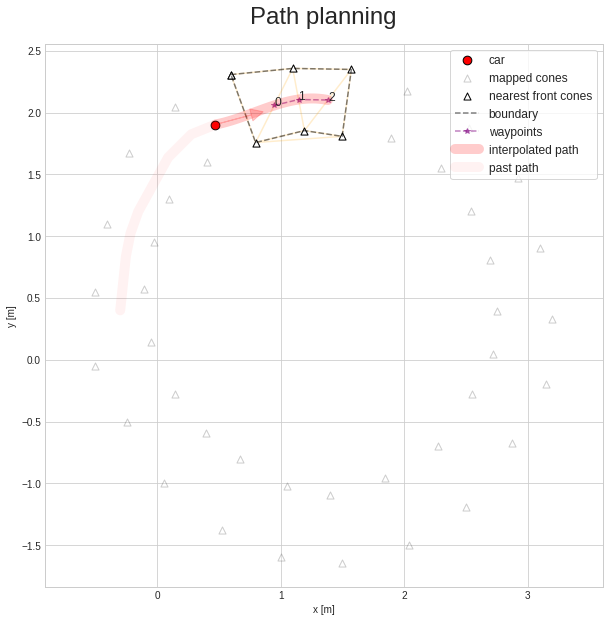

In [157]:
from concave_hull import concave_hull

boundary_points = concave_hull(front_cones, 0.5)

# find the midpoints that are inside the boundary
midpoints_inside = []
for i in range(len(midpoints)):
    if tr.point_is_inside_polygon(midpoints[i], boundary_points):
        midpoints_inside.append(midpoints[i])

midpoints_inside = np.array(midpoints_inside)

plt.scatter(car_pos[0], car_pos[1], c='r', marker='o', s=75, edgecolors='black', label='car')
plt.scatter(cone_positions[:, 0], cone_positions[:, 1], c='w', marker='^', s=50, edgecolors='black', alpha=0.2, label='mapped cones')
plt.arrow(car_pos[0], car_pos[1], 0.3 * np.cos(car_yaw), 0.3 * np.sin(car_yaw), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.2)
plt.triplot(front_cones[:, 0], front_cones[:, 1], tri.simplices.copy(), alpha=0.2, color='orange')

# # plot boundary_points
plt.scatter(boundary_points[:,0], boundary_points[:,1], c='w', marker='^', s=50, edgecolors='black', label='nearest front cones')
plt.plot(boundary_points[:,0], boundary_points[:,1], '--', color='k', alpha=0.5, label='boundary')

# # plot the midpoints
plt.plot(midpoints_inside[:,0], midpoints_inside[:,1], '*--', color='purple', alpha=0.5, label='waypoints')

# enumerate the midpoints
for i in range(len(midpoints_inside)):
    # move text a bit to the right
    plt.text(midpoints_inside[i,0], midpoints_inside[i,1], str(i), fontsize=12)

path = np.append([car_pos], midpoints_inside, axis=0)
x, y = path[:,0], path[:,1]
tck, u = splprep([x,y], s=0.1, k=3)
u_new = np.linspace(u.min(), u.max(), 50)
x_new, y_new = splev(u_new, tck, der=0)

tck_2, u_2 = splprep([x_new,y_new])
u_new_2 = np.linspace(u_2.min(), u_2.max(), 50)
x_new_2, y_new_2 = splev(u_new_2, tck_2, der=0)

# plt.plot(x_new_2, y_new_2, '-', color='red', label='interpolated path', linewidth=10, alpha=0.05)

plt.plot(x_new, y_new, '-', color='red', label='interpolated path', linewidth=10, alpha=0.2)
plt.plot(path1[:,0], path1[:,1], '-', color='red', label='past path', linewidth=10, alpha=0.05)

# extrapolation

# plt.xlim(0, 0.1)
# plt.ylim(min(front_cones[:, 1]) - 1, max(front_cones[:, 1]) + 1)
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.axis('equal')
plt.title('Path planning', fontsize=24, pad=20)
# increase size
plt.rcParams['figure.figsize'] = [10, 10]
plt.legend(frameon=True, fontsize=12, loc='upper right')
plt.savefig('img/test.png', dpi=300)

In [152]:
car_yaw = np.deg2rad(15)

## Plotting

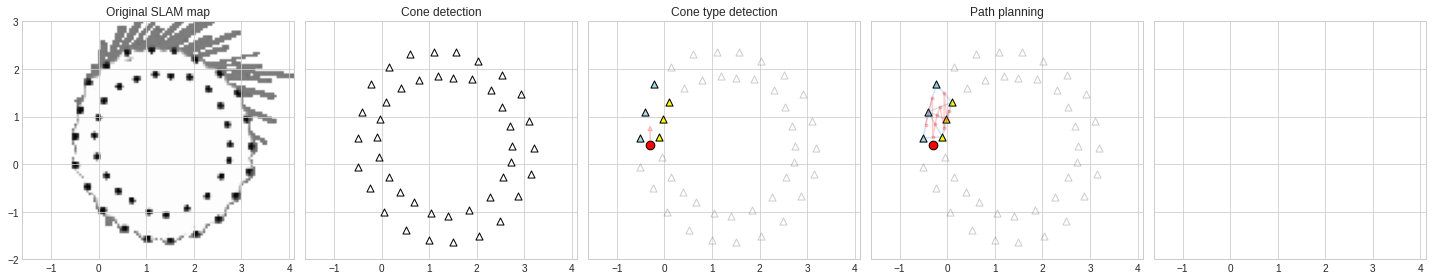

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Plot 1 : SLAM map
ax[0].imshow(map_data, cmap='gray', origin='lower', extent=extent)
ax[0].set_title('Original SLAM map')

# Plot 2 : Cone detection
ax[1].scatter(cone_positions[:, 0], cone_positions[:, 1], c='w', marker='^', s=50, edgecolors='black')
ax[1].set_title('Cone detection')

# Plot 3 : Cone type detection
ax[2].scatter(car_pos[0], car_pos[1], c='r', marker='o', s=75, edgecolors='black')
ax[2].scatter(cone_positions[:, 0], cone_positions[:, 1], c='w', marker='^', s=50, edgecolors='black', alpha=0.2)
ax[2].arrow(car_pos[0], car_pos[1], 0. * np.cos(car_yaw), 0.3 * np.sin(car_yaw), head_width=0.1, head_length=0.1, fc='r', ec='r', alpha=0.2)
ax[2].scatter(front_cones[left_cone_indices, 0], front_cones[left_cone_indices, 1], c='lightblue', marker='^', s=50, edgecolors='black')
ax[2].scatter(front_cones[right_cone_indices, 0], front_cones[right_cone_indices, 1], c='yellow', marker='^', s=50, edgecolors='black')
ax[2].set_title('Cone type detection')

# Plot 4 : Path planning
ax[3].scatter(car_pos[0], car_pos[1], c='r', marker='o', s=75, edgecolors='black')
ax[3].scatter(cone_positions[:, 0], cone_positions[:, 1], c='w', marker='^', s=50, edgecolors='black', alpha=0.2)
# ax[3].scatter(cone_positions[closest8_indices, 0], cone_positions[closest8_indices, 1], c='w', marker='^', s=50, edgecolors='black')
ax[3].scatter(front_cones[left_cone_indices, 0], front_cones[left_cone_indices, 1], c='lightblue', marker='^', s=50, edgecolors='black')
ax[3].scatter(front_cones[right_cone_indices, 0], front_cones[right_cone_indices, 1], c='yellow', marker='^', s=50, edgecolors='black')
ax[3].plot(midpoints[:, 0], midpoints[:, 1], 'r.-', alpha=0.2)
ax[3].triplot(front_cones[:, 0], front_cones[:, 1], tri.simplices.copy(), alpha=0.2)
ax[3].set_title('Path planning')

# General plot settings
[subplot.set_aspect('equal', adjustable="datalim") for subplot in ax]
[subplot.set_xlim(-1, 3.5) for subplot in ax]
[subplot.set_ylim(-2, 3) for subplot in ax]
plt.tight_layout()

## Animation

(-0.6888988096266985,
 3.3811012510210277,
 -1.841666667039196,
 2.558333267395693)

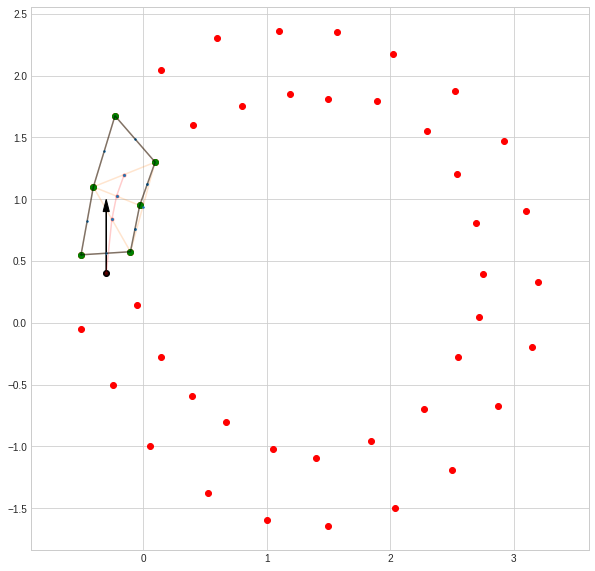

In [ ]:
car_yaw = np.deg2rad(90)

# front cones selection
distances = cdist([car_pos], cone_positions)[0]
mask = np.array([np.dot(cone_pos - car_pos, np.array([np.cos(car_yaw), np.sin(car_yaw)])) > 0 for cone_pos in cone_positions])
nearest_front_cones = np.array(cone_positions[mask][np.argsort(distances[mask])][:6])

# Calculate the midpoints of the delaunay triangles of the front cones excluding the ones that are outside the boundary
tri = Delaunay(nearest_front_cones)
midpoints = []
for i in range(len(tri.simplices)):
    midpoints.append((nearest_front_cones[tri.simplices[i][0]] + nearest_front_cones[tri.simplices[i][1]]) / 2)
    midpoints.append((nearest_front_cones[tri.simplices[i][0]] + nearest_front_cones[tri.simplices[i][2]]) / 2)
    midpoints.append((nearest_front_cones[tri.simplices[i][1]] + nearest_front_cones[tri.simplices[i][2]]) / 2)
midpoints = np.array(midpoints)

# remove duplicates
midpoints_ = np.unique(midpoints, axis=0)

# boundary points
boundary_points = concave_hull(nearest_front_cones, 0.5)

# find the midpoints that are inside the boundary
midpoints_inside = []
for i in range(len(midpoints)):
    if tr.point_is_inside_polygon(midpoints[i], boundary_points):
        midpoints_inside.append(midpoints[i])

midpoints_inside = tr.nnb_sorting(np.array(midpoints_inside))


path = np.append([car_pos], midpoints_inside, axis=0)

# plot the midpoints & path
plt.plot(path[:,0], path[:,1], 'r.-', alpha=0.2)
plt.plot(midpoints[:,0], midpoints[:,1], '.', markersize=3)
plt.triplot(nearest_front_cones[:,0], nearest_front_cones[:,1], tri.simplices.copy(), alpha=0.2)
plt.plot(boundary_points[:,0], boundary_points[:,1], 'k-', alpha=0.5)

plt.scatter(cone_positions[:,0], cone_positions[:,1], c='r')
plt.scatter(nearest_front_cones[:,0], nearest_front_cones[:,1], c='g')
plt.scatter (car_pos[0], car_pos[1], c='k')
plt.arrow(car_pos[0], car_pos[1], 0.5*np.cos(car_yaw), 0.5*np.sin(car_yaw), head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.axis('equal')

In [ ]:
path

array([[-0.3       ,  0.4       ],
       [-0.2538988 ,  0.83750004],
       [-0.2538988 ,  0.83750004],
       [-0.2163988 ,  1.02500004],
       [-0.2163988 ,  1.02500004],
       [-0.1538988 ,  1.20000005],
       [-0.1538988 ,  1.20000005]])

### Curvature 

[[0.47110121 1.90416666]
 [0.94610121 2.05833327]
 [1.14360126 2.10666663]
 [1.38110126 2.10250002]]


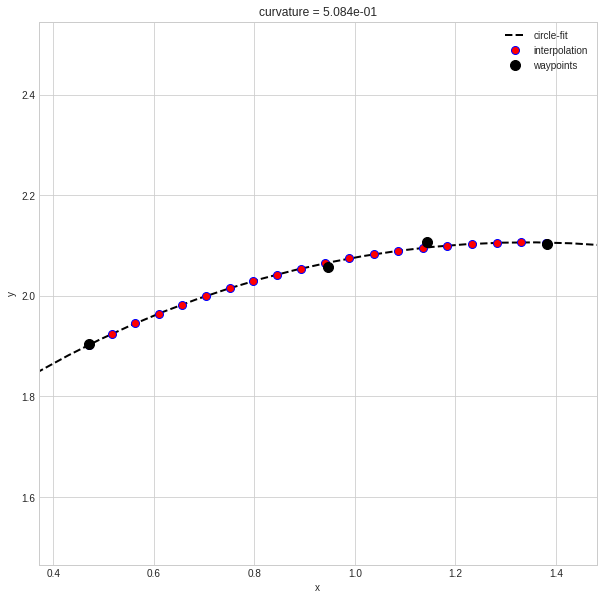

In [169]:
# import optimize
from scipy import interpolate, optimize

class ComputeCurvature:
    def __init__(self):
        """ Initialize some variables """
        self.xc = 0  # X-coordinate of circle center
        self.yc = 0  # Y-coordinate of circle center
        self.r = 0   # Radius of the circle
        self.xx = np.array([])  # Data points
        self.yy = np.array([])  # Data points

    def calc_r(self, xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((self.xx-xc)**2 + (self.yy-yc)**2)

    def f(self, c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        ri = self.calc_r(*c)
        return ri - ri.mean()

    def df(self, c):
        """ Jacobian of f_2b
        The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq"""
        xc, yc = c
        df_dc = np.empty((len(c), self.xx.size))

        ri = self.calc_r(xc, yc)
        df_dc[0] = (xc - self.xx)/ri                   # dR/dxc
        df_dc[1] = (yc - self.yy)/ri                   # dR/dyc
        df_dc = df_dc - df_dc.mean(axis=1)[:, np.newaxis]
        return df_dc

    def fit(self, xx, yy):
        self.xx = xx
        self.yy = yy
        center_estimate = np.r_[np.mean(xx), np.mean(yy)]
        center = optimize.leastsq(self.f, center_estimate, Dfun=self.df, col_deriv=True)[0]

        self.xc, self.yc = center
        ri = self.calc_r(*center)
        self.r = ri.mean()

        return 1 / self.r  # Return the curvature


# Apply code for an example

midpoints_inside_ = np.append([car_pos], midpoints_inside, axis=0)
midpoints_inside_ = np.unique(tr.nnb_sorting(midpoints_inside_, car_pos), axis=0)

print(midpoints_inside_)
x = midpoints_inside_[:,0]
y = midpoints_inside_[:,1]

tck, u = interpolate.splprep([x, y], s=2, k=2)
u_new = np.linspace(u.min(), u.max(), 20)
x_new, y_new = interpolate.splev(u_new, tck, der=0)
comp_curv = ComputeCurvature()
curvature = comp_curv.fit(x_new, y_new)

# Plot the result
theta_fit = np.linspace(-np.pi, np.pi, 180)
x_fit = comp_curv.xc + comp_curv.r*np.cos(theta_fit)
y_fit = comp_curv.yc + comp_curv.r*np.sin(theta_fit)
plt.plot(x_fit, y_fit, 'k--', label='circle-fit', lw=2)
plt.plot(x_new, y_new, 'ro', label='interpolation', ms=8, mec='b', mew=1)
plt.plot(x, y, 'k.', label='waypoints', ms=20)
plt.scatter(comp_curv.xc, comp_curv.yc, c='r', s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('curvature = {:.3e}'.format(curvature))
plt.axis('equal')
plt.xlim(min(x_new)-0.1, max(x_new)+0.1)
plt.ylim(min(y_new)-0.1, max(y_new)+0.1)

plt.legend()

plt.savefig('img/curvature.png', dpi=300)

plt.show()

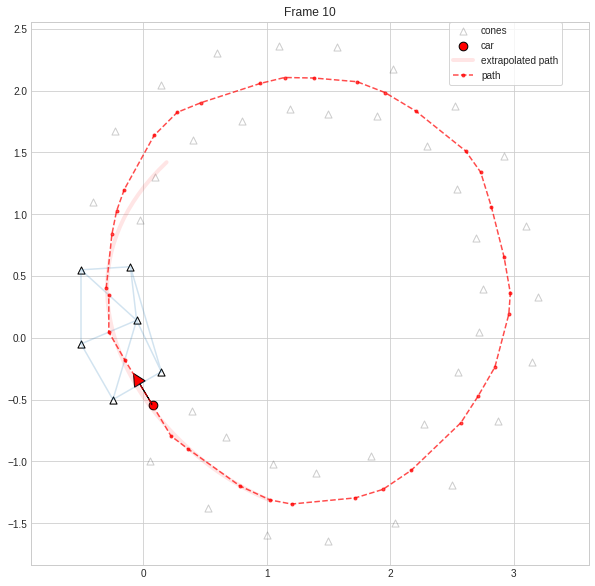

In [ ]:
from IPython.display import HTML
import matplotlib.animation

car_pos = np.array([-0.3, 0.4])
car_yaw = np.deg2rad(90)
step = -1
path = np.array([], dtype=np.float64).reshape(0, 2)
path = np.append(path, [car_pos], axis=0)

fig, ax = plt.subplots()

def animate(i):
    global car_pos, car_yaw, path, step

    if i == 0:
        return

    step += 1
    car_pos = path[-1]
    car_yaw = np.arctan2(path[-1][1] - path[-2][1], path[-1][0] - path[-2][0]) if len(path) > 1 else np.deg2rad(90)
    
    nearest_front_cones = tr.get_nearest_front_cones(car_pos, car_yaw, cone_positions, 6)
    
    tri = Delaunay(nearest_front_cones)
    midpoints = []
    for i in range(len(tri.simplices)):
        midpoints.append((nearest_front_cones[tri.simplices[i][0]] + nearest_front_cones[tri.simplices[i][1]]) / 2)
        midpoints.append((nearest_front_cones[tri.simplices[i][0]] + nearest_front_cones[tri.simplices[i][2]]) / 2)
        midpoints.append((nearest_front_cones[tri.simplices[i][1]] + nearest_front_cones[tri.simplices[i][2]]) / 2)
    midpoints = np.array(midpoints)

    # remove duplicates
    midpoints = np.unique(midpoints, axis=0)

    # boundary points
    boundary_points = concave_hull(nearest_front_cones, 0.5)

    # calculate center of mass of the boundary points
    center_of_mass = np.mean(boundary_points, axis=0)

    # find the midpoints that are inside the boundary
    midpoints_inside = []
    for i in range(len(midpoints)):
        if tr.point_is_inside_polygon(midpoints[i], boundary_points):
            midpoints_inside.append(midpoints[i])

    midpoints_inside = np.array(midpoints_inside)
    midpoints_inside = tr.nnb_sorting(midpoints_inside, car_pos)

    # ---- path ----

    path = np.append(path, midpoints_inside[:], axis=0)
    length_epath = min(12, min(8, max(4, path.shape[0])))
    x, y = path[-length_epath:,0], path[-length_epath:,1]
    tck_, u_ = splprep([x,y], s=2)
    u_new_ = np.linspace(u_.min(), u_.max(), 50)
    x_new_, y_new_ = splev(u_new_, tck_, der=0)


    # extrapolated 
    w = np.ones_like(x)
    w[-(length_epath//2):] *= 1.5
    tck, u = splprep([x,y], s=2, w = w)
    u_new = np.linspace(u.min(), u.max(), 50)
    x_new, y_new = splev(u_new*1.5, tck, der=0)

    # ---- plotting ---

    ax.clear()
    ax.cla()
    # cones
    ax.scatter(cone_positions[:, 0], cone_positions[:, 1], c='w', marker='^', s=50, edgecolors='black', alpha=0.2, label='cones')
    # car
    ax.scatter(car_pos[0], car_pos[1], c='r', marker='o', s=75, edgecolors='black', label='car')
    ax.arrow(car_pos[0], car_pos[1], 0.2 * np.cos(car_yaw), 0.2 * np.sin(car_yaw), head_width=0.1, head_length=0.1, fc='r', ec='k')
    # detected front cones
    ax.scatter(nearest_front_cones[:, 0], nearest_front_cones[:, 1], c='w', marker='^', s=50, edgecolors='black')
    # delaunay triangulation
    ax.triplot(nearest_front_cones[:, 0], nearest_front_cones[:, 1], tri.simplices.copy(), alpha=0.2)
    # center of mass
    # ax.scatter(center_of_mass[0], center_of_mass[1], c='b', marker='2', s=25, edgecolors='black', label='center of mass')
    # extrapolated path
    ax.plot(x_new, y_new, 'r-', alpha=0.1, linewidth=4, label='extrapolated path')
    #path
    ax.plot(path[:, 0], path[:, 1], 'r.--', alpha=0.7, label='path')
    ax.set_title('Frame {}'.format(step))
    plt.axis('equal')
    plt.legend(bbox_to_anchor=(.75, 1), loc='upper left', borderaxespad=0., frameon=True)


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=11+1, interval=400)

# ani.save('animation.gif', writer='imagemagick', fps=1)

HTML(ani.to_jshtml())

In [4]:
cone_positions

array([[ 1.57110122,  2.35000006],
       [ 1.09610122,  2.35833327],
       [ 0.59610121,  2.30833327],
       [ 2.02110123,  2.17500006],
       [ 0.1461012 ,  2.05000006],
       [ 2.52110124,  1.87500006],
       [ 1.19110129,  1.85499998],
       [ 1.89110131,  1.79500013],
       [ 1.49610122,  1.80833326],
       [ 0.79610121,  1.75833326],
       [-0.2288988 ,  1.67500005],
       [ 0.40443451,  1.60000005],
       [ 2.29610123,  1.55000005],
       [ 2.92110124,  1.47500005],
       [ 0.0961012 ,  1.30000005],
       [ 2.54110131,  1.20499997],
       [-0.40389881,  1.10000005],
       [-0.0288988 ,  0.95000004],
       [ 3.09610125,  0.90833344],
       [ 2.69110132,  0.80499996],
       [-0.1038988 ,  0.57500004],
       [-0.50389881,  0.55000004],
       [ 2.74610124,  0.39166664],
       [ 3.19610125,  0.32999996],
       [-0.0538988 ,  0.14166663],
       [ 2.72110124,  0.05000003],
       [-0.50389881, -0.04999997],
       [ 3.14610125, -0.19999997],
       [ 2.54610124,

In [3]:
nearest_front_cones = tr.get_nearest_front_cones(car_pos, car_yaw, cone_positions, count=6)
nearest_front_cones

array([[-0.50389881,  0.55000004],
       [-0.1038988 ,  0.57500004],
       [-0.0288988 ,  0.95000004],
       [-0.40389881,  1.10000005],
       [ 0.0961012 ,  1.30000005],
       [-0.2288988 ,  1.67500005]])

In [4]:
tr.extract_waypoints(nearest_front_cones, car_pos)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [2]:

def extract_waypoints(cone_positions, car_pos, car_yaw):
    boundary_polygon_points = concave_hull(cone_positions, 0.5)
    tri = Delaunay(nearest_front_cones)
    midpoints = np.empty((0, 2), dtype=np.float64)
    for i in range(len(tri.simplices)):
        # Calculate the midpoint of each triangle
        m1 = (cone_positions[tri.simplices[i][0]] + cone_positions[tri.simplices[i][1]]) / 2
        m2 = (cone_positions[tri.simplices[i][0]] + cone_positions[tri.simplices[i][2]]) / 2
        m3 = (cone_positions[tri.simplices[i][1]] + cone_positions[tri.simplices[i][2]]) / 2
        # # Add the midpoints to the valid list of midpoints if they are not already in the list and inside the boundary polygon
        
        if (m1 not in midpoints) and tr.point_is_inside_polygon(m1, boundary_polygon_points):
            midpoints = np.append(midpoints, [m1], axis=0)
        if (m2 not in midpoints) and tr.point_is_inside_polygon(m2, boundary_polygon_points):
            midpoints = np.append(midpoints, [m2], axis=0)
        if (m3 not in midpoints) and tr.point_is_inside_polygon(m3, boundary_polygon_points):
            midpoints = np.append(midpoints, [m3], axis=0)
        # midpoints = np.append(midpoints, [m2, m3], axis=0)
        
        print(midpoints.shape[0], midpoints.shape[1])
    midpoints = tr.nnb_sorting(midpoints, car_pos)
    return midpoints

midpoints = extract_waypoints(nearest_front_cones, car_pos, car_yaw)

NameError: name 'nearest_front_cones' is not defined

(-0.5338988073170186,
 0.12610120251774787,
 0.33624999729916455,
 1.7387500567175447)

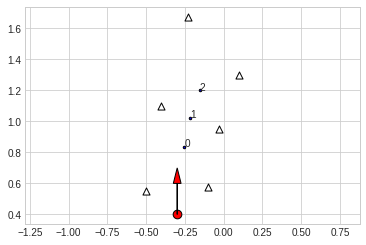

In [78]:
plt.scatter(nearest_front_cones[:, 0], nearest_front_cones[:, 1], c='w', marker='^', s=50, edgecolors='black')
plt.scatter(car_pos[0], car_pos[1], c='r', marker='o', s=75, edgecolors='black')
plt.arrow(car_pos[0], car_pos[1], 0.2 * np.cos(car_yaw), 0.2 * np.sin(car_yaw), head_width=0.05, head_length=0.1, fc='r', ec='k')
plt.scatter(midpoints[:, 0], midpoints[:, 1], c='b', marker='.', s=25, edgecolors='black')
# enumerate the points
for i, txt in enumerate(range(midpoints.shape[0])):
    plt.annotate(txt, (midpoints[i, 0], midpoints[i, 1]))
plt.axis('equal')

In [8]:
midpoints = np.array([[ 0.5,  0.5],[0.,7],[0, 7], [0, 7]])
midpoints.any([0, 7], axis=1)

TypeError: _any() got multiple values for argument 'axis'